# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация
Дата выдачи: 05.02.2021

Мягкий дедлайн: 01:59MSK 21.02.2021

Жесткий дедлайн: 01:59MSK 24.02.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import numpy as np


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        
        if self.classifier == 'logreg':
            # этот солвер сходится дольше дефолтного, но качество лучше
            self.clf = LogisticRegression(solver='sag')
        elif self.classifier == 'svm':
            self.clf = SVC(kernel='linear')
        else:
            raise TypeError('Wrong classifier: choose either "logreg" or "svm"')
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        
        # сокращаем размерность
        if self.use_PCA:
            self.pca = PCA(n_components=self.new_dim)
            self.pca.fit(X)
            X = self.pca.transform(X)
        else:
            # если не использовать PCA, то выходит низкая точность. Поэтому чиню это нормализацией
            self.sc = StandardScaler()
            X = self.sc.fit_transform(X)
            
        # генерируем случайные пары
        idx1 = np.random.choice(range(X.shape[0]), size=10**6)
        idx2 = np.random.choice(range(X.shape[0]), size=10**6)
        
        # выходит примерно 20 совпадений, не будем их учитывать
        non_coincidence = idx1 != idx2
        idx1 = idx1[non_coincidence]
        idx2 = idx2[non_coincidence]
        
        # оцениваем гиперпараметр
        sigma2 = np.median(np.sum((X[idx1]-X[idx2])**2, axis=1))
        
        # генерируем случайные признаки и сохраняем веса
        self.w = np.random.normal(loc=0, scale=np.sqrt(1/sigma2), size=(X.shape[1], self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, size=self.n_features)
        X = np.cos(np.dot(X, self.w)+self.b)
        
        self.clf.fit(X, y)
        
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        if self.classifier == 'svm':
            raise AttributeError("predict_proba is not available for 'svm' classifier")
        
        if self.use_PCA:
            X = self.pca.transform(X)
        else:
            self.sc = StandardScaler()
            X = self.sc.fit_transform(X)
            
        X = np.cos(np.dot(X, self.w)+self.b)
        y_pred_proba = self.clf.predict_proba(X)
        
        return y_pred_proba
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        
        if self.use_PCA:
            X = self.pca.transform(X)
        else:
            self.sc = StandardScaler()
            X = self.sc.fit_transform(X)
            
        X = np.cos(np.dot(X, self.w)+self.b)
        y_pred = self.clf.predict(X)
        
        return y_pred

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [4]:
import time
from sklearn.metrics import accuracy_score

def time_and_acc(model, X_train, y_train, X_test, y_test):
    """
    Функция возвращает время обучения и точность классификатора на тестовой выборке.
    """
    start_time = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time()-start_time
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return fit_time, accuracy

In [5]:
def compare_models(model_dict, X_train, y_train, X_test, y_test):
    """
    Функция сравнивает несколько моделей по скорости обучения и точности. 
    """
    models_list = []
    accuracy_list = []
    fit_time_list = []
    for model in model_dict:
        clf = model_dict[model]
        fit_time, accuracy = time_and_acc(clf, X_train, y_train, X_test, y_test)
        
        models_list.append(model)
        accuracy_list.append(accuracy)
        fit_time_list.append(fit_time)
        
    return models_list, accuracy_list, fit_time_list

In [19]:
sc = StandardScaler()
x_train_sc = sc.fit_transform(x_train)
x_test_sc = sc.transform(x_test)

In [20]:
model_dict = {'RFF logreg':RFFPipeline(classifier='logreg'),
              'RFF svm':RFFPipeline(classifier='svm'),
              'SVM linear':SVC(kernel='linear'),
              'SVM RBF':SVC(kernel='rbf')}

models_list, accuracy_list, fit_time_list = compare_models(model_dict, x_train_sc, y_train, x_test_sc, y_test)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [24]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

params = {'learning_rate':[0.3, 0.6, 0.9], 'n_estimators':[100, 500, 1000]}
xgb_clf = xgb.XGBClassifier()
grid = GridSearchCV(xgb_clf, params, cv=3, scoring='accuracy')
grid.fit(x_train_pca, y_train)

D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:22:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:24:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:26:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:28:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[19:35:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [25]:
# оптимальные параметры
print(grid.best_params_)

{'learning_rate': 0.3, 'n_estimators': 1000}


In [26]:
# обучим бустинг с оптимальными параметрами
xgb_clf = xgb.XGBClassifier(**grid.best_params_)
fit_time, accuracy = time_and_acc(xgb_clf, x_train_pca, y_train, x_test_pca, y_test)

# добавим показатели бустинга в списки
models_list.append('XGBOOST')
accuracy_list.append(accuracy)
fit_time_list.append(fit_time)

[19:53:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [27]:
import pandas as pd
res = pd.DataFrame({'Модель':models_list, 'Точность':accuracy_list, 'Время обучения (с)': fit_time_list})
res

,Модель,Точность,Время обучения (с)
0,RFF logreg,0.8727,169.307905
1,RFF svm,0.8735,644.151668
2,SVM linear,0.8370,1591.415372
3,SVM RBF,0.8836,536.383041
4,XGBOOST,0.8812,1106.665228


Самая высокая точность у бустинга (с понижением размерности до 50) и у ядрового SVM. Обе линейные модели с аппроксимацией ядра совсем немного отстают в точности от предыдущих двух моделей. По скорости обучения самая лучшая модель - логистическая регрессия на случайных признаках. Вывод: RFF позволяет быстро обучить линейную модель, качество которой сравнимо со сложными моделями.

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

В следующих двух заданиях я вернул дефолтный солвер, чтобы быстрее все это работало.

In [6]:
model_dict = {'new_dim = 50':RFFPipeline(new_dim=50),
              'new_dim = 200':RFFPipeline(new_dim=200),
              'new_dim = 500':RFFPipeline(new_dim=500),
              'use_PCA = False':RFFPipeline(use_PCA=False)}

models_list, accuracy_list, fit_time_list = compare_models(model_dict, x_train, y_train, x_test, y_test)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

In [7]:
import pandas as pd

res = pd.DataFrame({'Размерность':models_list, 'Точность':accuracy_list, 'Время обучения (с)': fit_time_list})
res

,Размерность,Точность,Время обучения (с)
0,new_dim = 50,0.8593,27.627402
1,new_dim = 200,0.8664,30.092712
2,new_dim = 500,0.8608,41.228536
3,use_PCA = False,0.8597,136.587915


Понижение размерности не сильно влияет на качество классификации, но зато позволяет сократить время обучения.

In [12]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
accuracy = []
n_features = range(100, 2001, 100)

for n in n_features:
    clf = RFFPipeline(n_features=n)
    clf.fit(x_train, y_train);
    acc = accuracy_score(y_test, clf.predict(x_test))
    accuracy.append(acc)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

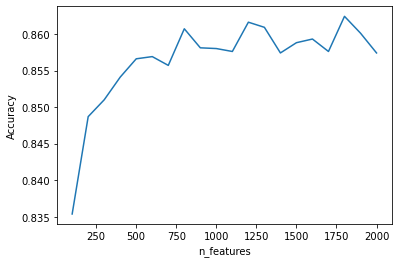

In [13]:
import matplotlib.pyplot as plt

plt.plot(n_features, accuracy)
plt.xlabel('n_features')
plt.ylabel('Accuracy');

При росте количества случайных признаков качество модели выходит на плато.

Чтобы честно сравнить RFF_logreg и RFF_svm, проведем 5 экспериментов и посмотрим на средние результаты. Здесь я снова установил для логистической регресии значение параметра `solver='sag'`.

In [9]:
from sklearn.model_selection import KFold

model_dict = {'RFF_logreg':RFFPipeline(classifier='logreg'), 'RFF_svm':RFFPipeline(classifier='svm')}
models_list, accuracy_list, fit_time_list = [], [], []

kf = KFold(n_splits=5)
    
for train_index, _ in kf.split(x_train):
    x_train_cur = x_train[train_index]
    y_train_cur = y_train[train_index]
    models_list_cur, accuracy_list_cur, fit_time_list_cur = compare_models(model_dict, x_train_cur, y_train_cur, x_test, y_test)
    
    models_list += models_list_cur
    accuracy_list += accuracy_list_cur
    fit_time_list += fit_time_list_cur

D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was re

In [10]:
res = pd.DataFrame({'Модель':models_list, 'Точность':accuracy_list, 'Время обучения (с)': fit_time_list})
res

,Модель,Точность,Время обучения (с)
0,RFF_logreg,0.8788,147.289845
1,RFF_svm,0.8800,378.809770
2,RFF_logreg,0.8758,149.231869
3,RFF_svm,0.8762,378.915178
4,RFF_logreg,0.8764,162.940516
5,RFF_svm,0.8810,563.374920
6,RFF_logreg,0.8792,187.433064
7,RFF_svm,0.8795,559.370711
8,RFF_logreg,0.8753,174.078404
9,RFF_svm,0.8794,517.032061


In [11]:
res.groupby('Модель').mean()

,Точность,Время обучения (с)
Модель,,
RFF_logreg,0.87710,164.194740
RFF_svm,0.87922,479.500528


В качестве нет сильно ощутимой разницы, но логистическая регрессия обучается гораздо быстрее.

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [13]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
from scipy.stats import chi

class ORFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        
        if self.classifier == 'logreg':
            # этот солвер сходится дольше дефолтного, но качество лучше
            self.clf = LogisticRegression(solver='sag')
        elif self.classifier == 'svm':
            self.clf = SVC(kernel='linear')
        else:
            raise TypeError('Wrong classifier: choose either "logreg" or "svm"')
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                
        # сокращаем размерность
        if self.use_PCA:
            self.pca = PCA(n_components=self.new_dim)
            self.pca.fit(X)
            X = self.pca.transform(X)
        else:
            # если не использовать PCA, то выходит низкая точность. Поэтому чиню это нормализацией
            self.sc = StandardScaler()
            X = self.sc.fit_transform(X)
            
        # генерируем случайные пары
        idx1 = np.random.choice(range(X.shape[0]), size=10**6)
        idx2 = np.random.choice(range(X.shape[0]), size=10**6)
        
        # выходит примерно 20 совпадений, не будем их учитывать
        non_coincidence = idx1 != idx2
        idx1 = idx1[non_coincidence]
        idx2 = idx2[non_coincidence]
        
        # оцениваем гиперпараметр
        sigma2 = np.median(np.sum((X[idx1]-X[idx2])**2, axis=1))
        
        # генерируем смещение
        self.b = np.random.uniform(-np.pi, np.pi, size=self.n_features)
        
        # сколько раз надо будет догенерировать признаков, если n_features не кратно количеству исходных признаков
        # или количеству признаков после снижения размерности.
        # это используется и для случая, когдла n_features меньше числа исходных признаков или ...
        residual = self.n_features % X.shape[1] 
        
        # в цикле несколько (или один) раз генерируем случайные признаки
        self.w = np.zeros((X.shape[1], self.n_features))
        for i in range(0, self.n_features, X.shape[1]):
            g = np.random.normal(size=(X.shape[1], X.shape[1]))
            q, _ = np.linalg.qr(g)
            s = np.diag(chi.rvs(X.shape[1], size=X.shape[1]))
            w = s.dot(q)/np.sqrt(sigma2)
            
            # если влезает вся квадратная матрица, добавляем ее, в противном случае - добавляем влезаемое кол-во столбцов
            if self.w[:,i:].shape[1] >= X.shape[1]:
                self.w[:,i:i+X.shape[1]] = w
            else:
                self.w[:,i:i+X.shape[1]] = w[:,:residual]

            
        X = np.cos(np.dot(X, self.w)+self.b)
        
        self.clf.fit(X, y)
        
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        if self.classifier == 'svm':
            raise AttributeError("predict_proba is not available for 'svm' classifier")
        
        if self.use_PCA:
            X = self.pca.transform(X)
        else:
            X = self.sc.transform(X)
            
        X = np.cos(np.dot(X, self.w)+self.b)        
        
        y_pred_proba = self.clf.predict_proba(X)
        
        return y_pred_proba
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        
        if self.use_PCA:
            X = self.pca.transform(X)
        else:
            X = self.sc.transform(X)
            
        X = np.cos(np.dot(X, self.w)+self.b)        
        
        y_pred = self.clf.predict(X)
        
        return y_pred

Аналогично проведем 5 экспериментов для сравнения ORF и RFF.

In [14]:
from sklearn.model_selection import KFold

model_dict = {'RFF logreg':RFFPipeline(),
              'ORF logreg':ORFPipeline()}

models_list, accuracy_list, fit_time_list = [], [], []

kf = KFold(n_splits=5)
    
for train_index, _ in kf.split(x_train):
    x_train_cur = x_train[train_index]
    y_train_cur = y_train[train_index]
    models_list_cur, accuracy_list_cur, fit_time_list_cur = compare_models(model_dict, x_train_cur, y_train_cur, x_test, y_test)
    
    models_list += models_list_cur
    accuracy_list += accuracy_list_cur
    fit_time_list += fit_time_list_cur

D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was re

In [17]:
import pandas as pd
res = pd.DataFrame({'Модель':models_list, 'Точность':accuracy_list, 'Время обучения (с)': fit_time_list})
res

,Модель,Точность,Время обучения (с)
0,RFF logreg,0.8727,146.619525
1,ORF logreg,0.8766,145.827482
2,RFF logreg,0.8777,146.219107
3,ORF logreg,0.8777,145.536233
4,RFF logreg,0.8794,150.986940
5,ORF logreg,0.8765,146.279641
6,RFF logreg,0.8770,145.659967
7,ORF logreg,0.8773,145.411296
8,RFF logreg,0.8760,145.775244
9,ORF logreg,0.8783,145.083532


In [18]:
res.groupby('Модель').mean()

,Точность,Время обучения (с)
Модель,,
ORF logreg,0.87728,145.627637
RFF logreg,0.87656,147.052157


В среднем, точность ORF немного выше и обучается быстрее.Трудно назвать эту разницу существенной.

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [27]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪